In [ ]:
import xarray as xr

# ============================================================
# DATA PATHS - Update these paths for your local system
# ============================================================
# Path to model output file
nc_file = "./data/model_results/202601021751_with_inflow.nc"

# Open the NetCDF file
ds = xr.open_dataset(nc_file)

print("═" * 70)
print("  NETCDF FILE CONTENTS")
print("═" * 70)

#   QUICK SUMMARY - ALL VARIABLE NAMES


print("\n📋 ALL VARIABLES IN FILE (Quick List):")
print("-" * 70)
all_vars = list(ds.data_vars.keys())
for i, var_name in enumerate(all_vars, 1):
    print(f"  {i:2d}. {var_name}")

print(f"\n  ➜ Total: {len(all_vars)} variables\n")


#   DETAILED INFORMATION


# Print dimensions
print("\n📏 DIMENSIONS:")
print("-" * 70)
for dim_name, dim_size in ds.dims.items():
    print(f"  {dim_name:20s} : {dim_size}")

# Print coordinates
print("\n🌍 COORDINATES:")
print("-" * 70)
for coord_name in ds.coords:
    coord = ds.coords[coord_name]
    if coord.size > 5:
        print(f"  {coord_name:20s} : shape {coord.shape}, dtype={coord.dtype}")
    else:
        print(f"  {coord_name:20s} : {coord.values}")

# Print data variables with details
print("\n📊 DATA VARIABLES (Detailed):")
print("-" * 70)
for var_name in ds.data_vars:
    var = ds[var_name]
    print(f"\n  ▸ {var_name}")
    print(f"    Shape      : {var.shape}")
    print(f"    Dimensions : {var.dims}")
    print(f"    Data type  : {var.dtype}")
    
    # Show variable attributes if available
    if var.attrs:
        print(f"    Attributes :")
        for attr_name, attr_value in var.attrs.items():
            print(f"      - {attr_name}: {attr_value}")
    
    # Show basic statistics for time-series variables
    if 'time' in var.dims and var.size > 0:
        try:
            print(f"    Stats      : min={float(var.min()):.4f}, max={float(var.max()):.4f}, mean={float(var.mean()):.4f}")
        except:
            pass

# Print global attributes
if ds.attrs:
    print("\n🔖 GLOBAL ATTRIBUTES:")
    print("-" * 70)
    for attr_name, attr_value in ds.attrs.items():
        print(f"  {attr_name}: {attr_value}")


#   XARRAY DISPLAY 


print("\n" + "═" * 70)
print("  XARRAY DATASET STRUCTURE (Complete View)")
print("═" * 70)
print("\n")
print(ds)

print("\n" + "═" * 70)
print(f"  Total variables: {len(ds.data_vars)}")
print(f"  File size: {ds.nbytes / 1024**2:.2f} MB")
print("═" * 70)

# Close the dataset
ds.close()


══════════════════════════════════════════════════════════════════════
  STARTING GROUNDWATER INFLOW VISUALIZATION
══════════════════════════════════════════════════════════════════════

Loading model results and stream network...
  Grid size: 220 rows × 136 columns
Filtering panel (c) data by persistent GW inflow...
  Active inflow pixels: 665

Loading field measurement zones...
  Loaded 4 GW zones and 3 SW zones

Building figure...
  Panel (a): Winter vs Spring...
  Panel (b): Early vs Mid Summer...
  Panel (c): 4-month overview...

══════════════════════════════════════════════════════════════════════
  ✓ FIGURE COMPLETE
══════════════════════════════════════════════════════════════════════


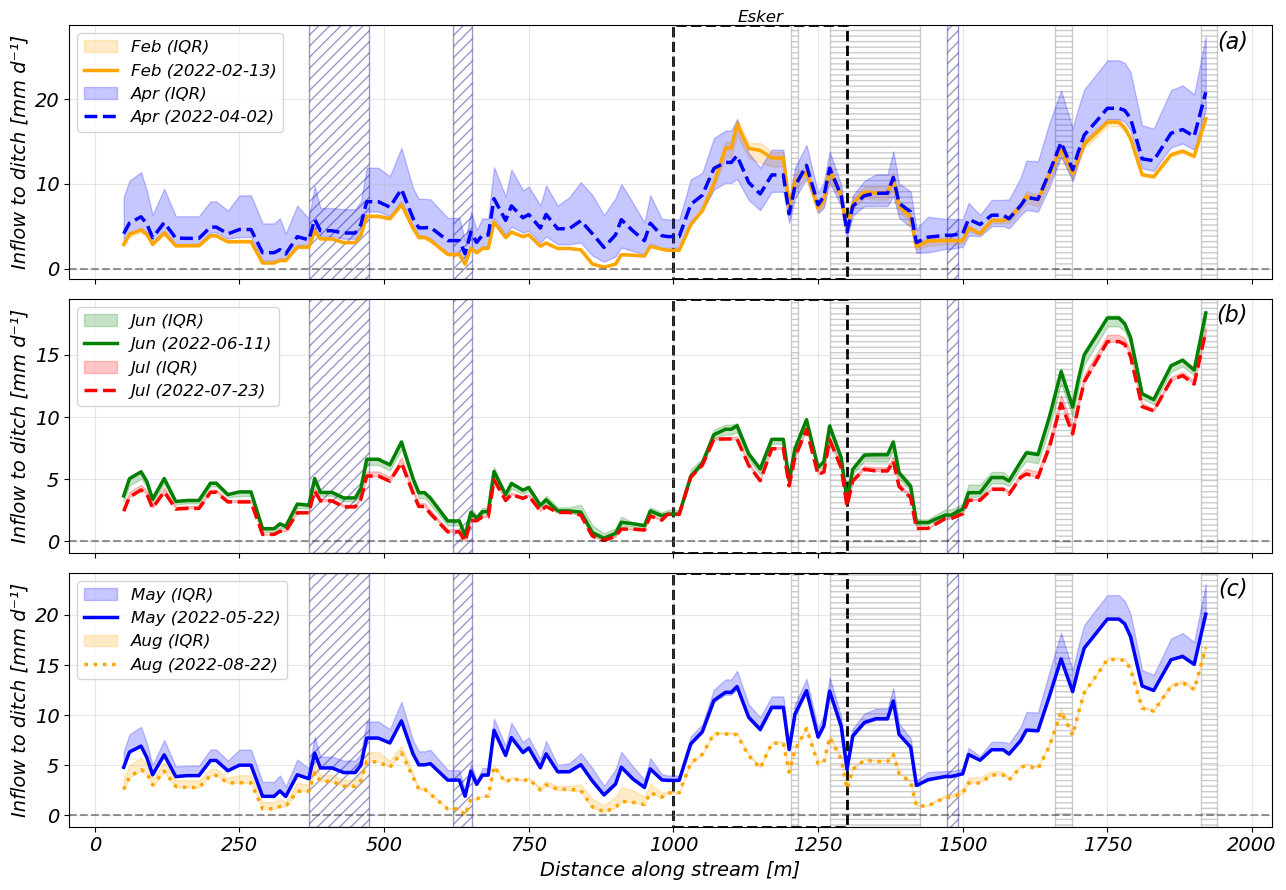

In [ ]:

#   GROUNDWATER INFLOW TO STREAMS - 3-PANEL FIGURE (CLEAN VERSION)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rasterio

print("═" * 70)
print("  STARTING GROUNDWATER INFLOW VISUALIZATION")
print("═" * 70)

# ───────────────────────────────────────────────────────────────────────
#  CONFIGURATION: File Paths
# ───────────────────────────────────────────────────────────────────────

# Model results with post-processed GW inflow variable
MODEL_OUTPUT = "./data/model_results/202601021751_with_inflow.nc"

# Stream network raster (values = distance along channel in meters)
STREAM_NETWORK = "./data/WBT_data/pallas_16/stream_lengths_burned_clipped.tif"

# Field measurement zones from DTS observations
GW_ZONES_FILE = "./GW_inflow_locations_slope.csv"
SW_ZONES_FILE = "./SW_inflow_locations_slope.csv"


#  STEP 1: Load Data


print("\nLoading model results and stream network...")

# Open NetCDF with model outputs
results = xr.open_dataset(MODEL_OUTPUT)

# Open stream network raster
with rasterio.open(STREAM_NETWORK) as src:
    stream_data = src.read(1)

# Get compatible grid dimensions
min_rows = min(stream_data.shape[0], results["inflow_to_ditch"].shape[1])
min_cols = min(stream_data.shape[1], results["inflow_to_ditch"].shape[2])

print(f"  Grid size: {min_rows} rows × {min_cols} columns")

#  STEP 2: Pre-process Data for Panel (c)


print("Filtering panel (c) data by persistent GW inflow...")

# Calculate mean netflow to identify persistent inflow locations
netflow = results["deep_netflow_to_ditch"]
mean_netflow = netflow.mean(dim="time")
positive_mean_mask = (mean_netflow > 0)

# Apply mask to show only persistent GW inflow zones
inflow_masked = results["inflow_to_ditch"] * positive_mean_mask

print(f"  Active inflow pixels: {positive_mean_mask.sum().item()}")


#  HELPER FUNCTIONS


def load_field_zones(csv_file):
    """
    Load field measurement zone boundaries from CSV file.
    Returns list of (start_m, end_m) tuples.
    """
    df = pd.read_csv(csv_file)
    
    # Handle different possible column names
    if {"x_start_m", "x_end_m"}.issubset(df.columns):
        return list(zip(df["x_start_m"].values, df["x_end_m"].values))
    elif {"start_m", "end_m"}.issubset(df.columns):
        return list(zip(df["start_m"].values, df["end_m"].values))
    else:
        raise ValueError(f"Cannot find zone columns in {csv_file}")


def add_hatched_zones(ax, zone_segments, *, color, pattern, transparency=0.4):
    """
    Add hatched rectangles to mark field measurement zones.
    
    """
    for start_m, end_m in zone_segments:
        ax.axvspan(start_m, end_m, 
                   facecolor="none", 
                   edgecolor=color, 
                   hatch=pattern, 
                   alpha=transparency, 
                   zorder=0)


def mark_esker_zone(ax, *, start_m=1000, end_m=1300):
    """Add dashed outline for esker geological feature."""
    ax.axvspan(start_m, end_m, 
               facecolor="none", 
               edgecolor="black", 
               linestyle="--", 
               linewidth=2, 
               zorder=1)


def find_date_index(date_string):
    """Find time index in model results for a given date string."""
    target_date = pd.Timestamp(date_string).date()
    for i in range(len(results.time)):
        if pd.Timestamp(results.time[i].values).date() == target_date:
            return i
    return None


def extract_stream_profile(inflow_data, date_str, start_date, end_date):
    """
    Extract inflow along stream for one date, plus monthly percentiles.
    
    Returns DataFrame with: 
    - stream_length (m)
    - inflow (daily value)
    - p25, p75 (monthly 25th/75th percentiles - IQR)
    - smoothed versions of all above
    """
    # Get index for the specific date
    idx = find_date_index(date_str)
    if idx is None:
        return None
    
    # Extract daily inflow
    daily_slice = inflow_data.isel(time=idx)
    
    # Get time range for monthly stats
    i1 = find_date_index(start_date)
    i2 = find_date_index(end_date)
    month_block = inflow_data.isel(time=slice(i1, i2 + 1))
    
    # Calculate interquartile range (more robust than min/max)
    p25 = month_block.quantile(0.25, dim="time")
    p75 = month_block.quantile(0.75, dim="time")
    
    # Extract values at stream pixels
    rows = []
    for r in range(min_rows):
        for c in range(min_cols):
            if stream_data[r, c] > 0:  # Only process stream pixels
                rows.append({
                    "stream_length": stream_data[r, c],
                    "inflow": daily_slice.values[r, c],
                    "p25": p25.values[r, c],
                    "p75": p75.values[r, c]
                })
    
    # Convert to DataFrame and sort by distance
    df = pd.DataFrame(rows).sort_values("stream_length")
    
    # Apply 5-point smoothing for cleaner visualization
    df["inflow_roll"] = df["inflow"].rolling(5, center=True, min_periods=1).mean()
    df["p25_roll"] = df["p25"].rolling(5, center=True, min_periods=1).mean()
    df["p75_roll"] = df["p75"].rolling(5, center=True, min_periods=1).mean()
    
    return df


def build_panel(ax, inflow_data, dates_dict, periods_dict, colors, styles, panel_label):
    """
    Build one panel of the 3-panel figure.

    panel_label : '(a)', '(b)', or '(c)'
    """
    
    # Add background zones first (so they appear behind data)
    add_hatched_zones(ax, gw_zones, color="grey", pattern="---", transparency=0.4)
    add_hatched_zones(ax, sw_zones, color="navy", pattern="///", transparency=0.4)
    mark_esker_zone(ax)
    
    # Process and plot each month
    for month_name in dates_dict.keys():
        date_to_plot = dates_dict[month_name]
        start_date, end_date = periods_dict[month_name]
        
        # Extract data
        df = extract_stream_profile(inflow_data, date_to_plot, start_date, end_date)
        if df is None:
            print(f"  Warning: Could not extract data for {month_name}")
            continue
        
        # Get abbreviated month name for legend
        month_abbrev = pd.to_datetime(start_date).strftime("%b")
        
        # Plot shaded IQR band
        ax.fill_between(df["stream_length"], 
                        df["p25_roll"], 
                        df["p75_roll"],
                        color=colors[month_name], 
                        alpha=0.22,
                        label=f"{month_abbrev} (IQR)")
        
        # Plot daily profile line
        ax.plot(df["stream_length"], 
                df["inflow_roll"],
                color=colors[month_name], 
                linestyle=styles[month_name],
                linewidth=2.5, 
                label=f"{month_abbrev} ({date_to_plot})")
    
    # Format the panel
    ax.axhline(0, color="k", linestyle="--", alpha=0.4)  # Zero reference line
    ax.set_ylabel("Inflow to ditch [mm d⁻¹]", fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=14)
    ax.text(0.98, 0.98, panel_label, 
            transform=ax.transAxes, ha="right", va="top", fontsize=16)
    ax.legend(fontsize=12, loc="upper left")



#  STEP 3: Load Field Measurement Zones


print("\nLoading field measurement zones...")
gw_zones = load_field_zones(GW_ZONES_FILE)
sw_zones = load_field_zones(SW_ZONES_FILE)
print(f"  Loaded {len(gw_zones)} GW zones and {len(sw_zones)} SW zones")


#  STEP 4: Create the 3-Panel Figure


# Initialize figure with 3 vertically stacked subplots
fig, axes = plt.subplots(3, 1, figsize=(13, 9), sharex=True)


#  PANEL (a): Winter (February) vs Spring (March)



build_panel(
    ax=axes[0],
    inflow_data=results["inflow_to_ditch"],
    dates_dict={"February": "2022-02-13", 
                "May": "2022-04-02"},
    periods_dict={"February": ("2022-02-01", "2022-02-28"),
                  "May": ("2022-04-01", "2022-04-30")},
    colors={"February": "orange", "May": "blue"},
    styles={"February": "-", "May": "--"},
    panel_label="(a)"
)


#  PANEL (b): Early Summer (June) vs Mid Summer (July)


print("  Panel (b): Early vs Mid Summer...")

build_panel(
    ax=axes[1],
    inflow_data=results["inflow_to_ditch"],
    dates_dict={"June": "2022-06-11", 
                "July": "2022-07-23"},
    periods_dict={"June": ("2022-06-01", "2022-06-30"),
                  "July": ("2022-07-01", "2022-07-31")},
    colors={"June": "green", "July": "red"},
    styles={"June": "-", "July": "--"},
    panel_label="(b)"
)


#  PANEL (c): Spring through Late Summer (4-month overview)
#  Uses filtered data showing only persistent GW inflow zones


print("  Panel (c): 4-month overview...")

build_panel(
    ax=axes[2],
    inflow_data=inflow_masked,  # Filtered for persistent inflow
    dates_dict={"May": "2022-05-22", 
                "August": "2022-08-22"},
    periods_dict={"May": ("2022-05-01", "2022-05-31"),
                  "June": ("2022-06-01", "2022-06-30"),
                  "July": ("2022-07-01", "2022-07-31"),
                  "August": ("2022-08-01", "2022-08-31")},
    colors={"May": "blue", "June": "green", "July": "red", "August": "orange"},
    styles={"May": "-", "June": "--", "July": "-.", "August": ":"},
    panel_label="(c)"
)


#  FINAL TOUCHES


# Add "Esker" label to top panel
esker_center = 1150  # Center of esker zone (1000-1300m)
axes[0].text(esker_center, axes[0].get_ylim()[1], "Esker",
             ha="center", va="bottom", fontsize=12, rotation=0)

# Add x-axis label to bottom panel
axes[2].set_xlabel("Distance along stream [m]", fontsize=14)

# Optimize layout
plt.tight_layout()

print("\n" + "═" * 70)
print("  ✓ FIGURE COMPLETE")
print("═" * 70)

# Display the figure
plt.show()


In [ ]:
# ═══════════════════════════════════════════════════════════════════════
#   INSPECT NETCDF MODEL OUTPUT FILE
#   View available variables, dimensions, and attributes
# ═══════════════════════════════════════════════════════════════════════

import xarray as xr

# Path to model output file
nc_file = "./data/model_results/202601021751_with_inflow.nc"

# Open the NetCDF file
ds = xr.open_dataset(nc_file)

print("═" * 70)
print("  NETCDF FILE CONTENTS")
print("═" * 70)

# ═══════════════════════════════════════════════════════════════════════
#   QUICK SUMMARY - ALL VARIABLE NAMES
# ═══════════════════════════════════════════════════════════════════════

print("\n📋 ALL VARIABLES IN FILE (Quick List):")
print("-" * 70)
all_vars = list(ds.data_vars.keys())
for i, var_name in enumerate(all_vars, 1):
    print(f"  {i:2d}. {var_name}")

print(f"\n  ➜ Total: {len(all_vars)} variables\n")

# ═══════════════════════════════════════════════════════════════════════
#   DETAILED INFORMATION
# ═══════════════════════════════════════════════════════════════════════

# Print dimensions
print("\n📏 DIMENSIONS:")
print("-" * 70)
for dim_name, dim_size in ds.dims.items():
    print(f"  {dim_name:20s} : {dim_size}")

# Print coordinates
print("\n🌍 COORDINATES:")
print("-" * 70)
for coord_name in ds.coords:
    coord = ds.coords[coord_name]
    if coord.size > 5:
        print(f"  {coord_name:20s} : shape {coord.shape}, dtype={coord.dtype}")
    else:
        print(f"  {coord_name:20s} : {coord.values}")

# Print data variables with details
print("\n📊 DATA VARIABLES (Detailed):")
print("-" * 70)
for var_name in ds.data_vars:
    var = ds[var_name]
    print(f"\n  ▸ {var_name}")
    print(f"    Shape      : {var.shape}")
    print(f"    Dimensions : {var.dims}")
    print(f"    Data type  : {var.dtype}")
    
    # Show variable attributes if available
    if var.attrs:
        print(f"    Attributes :")
        for attr_name, attr_value in var.attrs.items():
            print(f"      - {attr_name}: {attr_value}")
    
    # Show basic statistics for time-series variables
    if 'time' in var.dims and var.size > 0:
        try:
            print(f"    Stats      : min={float(var.min()):.4f}, max={float(var.max()):.4f}, mean={float(var.mean()):.4f}")
        except:
            pass

# Print global attributes
if ds.attrs:
    print("\n🔖 GLOBAL ATTRIBUTES:")
    print("-" * 70)
    for attr_name, attr_value in ds.attrs.items():
        print(f"  {attr_name}: {attr_value}")

# ═══════════════════════════════════════════════════════════════════════
#   XARRAY NATIVE DISPLAY (Most Complete View)
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "═" * 70)
print("  XARRAY DATASET STRUCTURE (Complete View)")
print("═" * 70)
print("\n")
print(ds)

print("\n" + "═" * 70)
print(f"  Total variables: {len(ds.data_vars)}")
print(f"  File size: {ds.nbytes / 1024**2:.2f} MB")
print("═" * 70)

# Close the dataset
ds.close()


══════════════════════════════════════════════════════════════════════
  NETCDF FILE CONTENTS
══════════════════════════════════════════════════════════════════════

📋 ALL VARIABLES IN FILE (Quick List):
----------------------------------------------------------------------
   1. parameters_lai_conif
   2. parameters_lai_decid_max
   3. parameters_lai_shrub
   4. parameters_lai_grass
   5. parameters_hc
   6. parameters_cf
   7. parameters_org_id
   8. parameters_root_id
   9. parameters_deep_id
  10. parameters_elevation
  11. parameters_lat
  12. parameters_lon
  13. parameters_streams
  14. parameters_lakes
  15. parameters_cmask
  16. parameters_cmask_bi
  17. parameters_twi
  18. forcing_air_temperature
  19. forcing_relative_humidity
  20. forcing_precipitation
  21. forcing_vapor_pressure_deficit
  22. forcing_global_radiation
  23. forcing_wind_speed
  24. forcing_wind_direction
  25. bucket_pond_storage
  26. bucket_moisture_top
  27. bucket_moisture_root
  28. bucket_psi_root

C:\Users\pparvizi24\AppData\Local\Temp\ipykernel_24696\4224095323.py:37: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for dim_name, dim_size in ds.dims.items():


    Stats      : min=0.0000, max=26.9000, mean=1.2527

  ▸ bucket_surface_runoff
    Shape      : (364, 221, 136)
    Dimensions : ('time', 'lat', 'lon')
    Data type  : float32
    Attributes :
      - units: surface runoff [mm d-1]
    Stats      : min=0.0000, max=97.7636, mean=0.3776

  ▸ bucket_evaporation
    Shape      : (364, 221, 136)
    Dimensions : ('time', 'lat', 'lon')
    Data type  : float32
    Attributes :
      - units: evaporation from soil surface [mm d-1]
    Stats      : min=0.0000, max=3.9909, mean=0.2145

  ▸ bucket_drainage
    Shape      : (364, 221, 136)
    Dimensions : ('time', 'lat', 'lon')
    Data type  : float32
    Attributes :
      - units: drainage from root layer [mm d-1]
    Stats      : min=0.0000, max=49.0557, mean=0.5576

  ▸ bucket_water_storage
    Shape      : (364, 221, 136)
    Dimensions : ('time', 'lat', 'lon')
    Data type  : float32
    Attributes :
      - units: bucket water storage (top and root) [mm d-1]
    Stats      : min=23.6